# A comparison of actual thrombolysis rates across hospitals: subgroup analysis

## Plain English summary

We have previously predicted the thrombolysis use in subgroups, if all hopsitals saw the same 10 thousand patients. In this notebook we look at subgroup analysis of actual thrombolysis use. One difference between this and the previous work, is that when we look at observed thrombolysis use, then the patients in the subgroups are different at each hopsital, but we can still look for agreement in general patterns.

As with the predicted thrombolysis use (if all hopsitals saw the same patients), we see the same patterns. All stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower  thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients.

## Data and analysis

This analysis is for patients who arrive within 4 hours of known stroke onset. The data is the observed thrombolsyis use at each hopsital (not modelled/predicted thrombolysis use).

We look at thrombolysis use by subgroup in four groups (in addiitonal to total thrombolysis use).
  * Mild stroke severity (NIHSS < 5)
  * No precise onset time
  * Existing pre-stroke disability (mRS > 2)
  * An *ideal* thrombolysable patient:
    * Stroke severity NIHSS in range 10-25
    * Arrival-to-scan time < 30 minutes
    * Stroke type = infarction
    * Precise onset time = True
    * Prior diability level (mRS) = 0
    * No use of AF anticoagulants
    * Onset-to-arrival time < 90 minutes
    * Age < 80 years
    * Onset during sleep = False

## Observations

* The observed and predicted subgroup analysis show very similar general patterns (with r-sqaured=0.95). The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, all had reduced thrombolysis use, and combining these non-ideal features reduced thrombolysis use further.

* The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, tended to reduce in parallel, along with total thrombolysis use, suggesting a shared caution in use of thrombolysis in 'less ideal' patients. 

* Some differences exist:
  * The use of thrombolysi in *ideal* patients is a little low in the observed vs actual results (mean hopsital thrombolysis use = 89% vs 99%).
  * The predicted results show a stronger effect of combining non-ideal features.
  * The observed thrombolysis rate shows higher between-hopsital variation than the predicted thrombolysis rate. This may be partly explained by the observed thrombolsysi rate being on different patients at each hospital, but may also be partly exlained by actual use of thrombolysis being slightly more variable than predicted thrombolysis use (which will follow general hospial patterns, and will not include, for example, between-clinician variation at each hospital).

## Import packages

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## Import data

In [2]:
# Load one k-fold, and join to get full data
data_loc = '../data/kfold_5fold/'
train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')
data = pd.concat([train, test])

# Restrict data fields and rename
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')
data = data[key_features]
data.rename(columns=feature_name_dict, inplace=True)



In [3]:
data.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
0,14.0,0,24.0,1,0,APXEE8191H,0,106.0,0,92.5,0
1,8.0,1,27.0,1,0,EQZZZ5658G,0,144.0,0,72.5,1
2,18.0,1,2.0,0,0,QOAPO4699N,0,83.0,0,72.5,1
3,19.0,1,12.0,1,4,JINXD0311F,0,78.0,0,57.5,1
4,22.0,1,27.0,1,3,HBFCN1575G,1,145.0,0,82.5,1


## Get thrombolysis use in subgroups at each hopsital

In [4]:
results=dict()

# Group data by hopsital
grouped_data = data.groupby('Stroke team')

# Loop through hopsitals
for hospital, hosp_data in grouped_data:
    hosp_results = dict()
    
    # Thrombolysis for all patients 
    hosp_results['All patients'] = hosp_data['Thrombolysis'].mean()

    # Thrombolysis for ideal patients
    mask = ((hosp_data['Stroke severity'] <= 25) &
        (hosp_data['Stroke severity'] >= 10) & 
        (hosp_data['Arrival-to-scan time'] <= 30) &
        (hosp_data['Infarction'] == 1) &
        (hosp_data['Precise onset time'] == 1) &
        (hosp_data['Prior disability level'] == 0) &
        (hosp_data['Use of AF anticoagulants'] == 0) &
        (hosp_data['Onset-to-arrival time'] <= 90) &
        (hosp_data['Age'] < 80) &
        (hosp_data['Onset during sleep'] == 0)
        )
    hosp_results['Ideal'] = hosp_data[mask]['Thrombolysis'].mean()

    # Mild stroke (NIHSS < 5)
    mask = hosp_data['Stroke severity'] < 5
    hosp_results['NIHSS < 5'] = hosp_data[mask]['Thrombolysis'].mean()

    # No precise onset time
    mask = hosp_data['Precise onset time'] == 0
    hosp_results['No precise onset'] = hosp_data[mask]['Thrombolysis'].mean()

    # Prior disability
    mask = hosp_data['Prior disability level'] > 2
    hosp_results['mRS > 2'] = hosp_data[mask]['Thrombolysis'].mean()

    # Age
    mask = hosp_data['Age'] > 80 
    hosp_results['Age > 80'] = hosp_data[mask]['Thrombolysis'].mean()

    # Mild stroke (NIHSS < 5) and no precise onset
    mask = ((hosp_data['Stroke severity'] < 5) & 
            (hosp_data['Precise onset time'] == 0))
    hosp_results['NIHSS + Precise'] = hosp_data[mask]['Thrombolysis'].mean()

    # Mild stroke (NIHSS < 5) and prestroke disability
    mask = ((hosp_data['Stroke severity'] < 5) & 
            (hosp_data['Prior disability level'] > 2))
    hosp_results['NIHSS + Disability'] = hosp_data[mask]['Thrombolysis'].mean()

    # No precise onset and prestroke disability
    mask = ((hosp_data['Precise onset time'] == 0) & 
            (hosp_data['Prior disability level'] > 2))
    hosp_results['Precise + Disability'] = hosp_data[mask]['Thrombolysis'].mean()

    # NIHSS < 5, No precise onset, and prestroke disability
    mask = ((hosp_data['Stroke severity'] < 5) &
            (hosp_data['Precise onset time'] == 0) & 
            (hosp_data['Prior disability level'] > 2))
    hosp_results['NIHSS + Precise + Disability'] = hosp_data[mask]['Thrombolysis'].mean()

    # Add to all results
    results[hospital] = hosp_results

results = pd.DataFrame(results).T
results *= 100 # (Convert to percent)
results

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,Age > 80,NIHSS + Precise,NIHSS + Disability,Precise + Disability,NIHSS + Precise + Disability
AGNOF1041H,35.246843,82.051282,15.210356,18.623482,21.379310,29.189189,2.409639,0.000000,8.771930,0.000000
AKCGO9726K,36.974790,86.206897,23.049645,18.539326,33.887043,35.044248,8.275862,10.606061,17.177914,4.761905
AOBTM3098N,21.880342,80.000000,2.690583,5.813953,11.926606,18.309859,0.000000,0.000000,5.555556,0.000000
APXEE8191H,22.648084,100.000000,6.329114,12.356322,13.636364,20.270270,2.597403,0.000000,5.333333,0.000000
ATDID5461S,24.038462,100.000000,14.150943,2.727273,9.756098,16.265060,0.000000,7.142857,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,24.605678,87.500000,5.185185,2.409639,11.475410,21.568627,0.000000,5.555556,0.000000,0.000000
YQMZV4284N,23.617021,100.000000,7.389163,6.074766,20.754717,22.594142,0.000000,2.439024,5.681818,0.000000
ZBVSO0975W,25.000000,76.923077,12.435233,14.705882,20.512821,23.560209,22.222222,0.000000,4.166667,0.000000
ZHCLE1578P,22.363946,100.000000,6.067416,22.070145,18.181818,20.000000,6.067416,2.325581,18.279570,2.325581


## Plot results

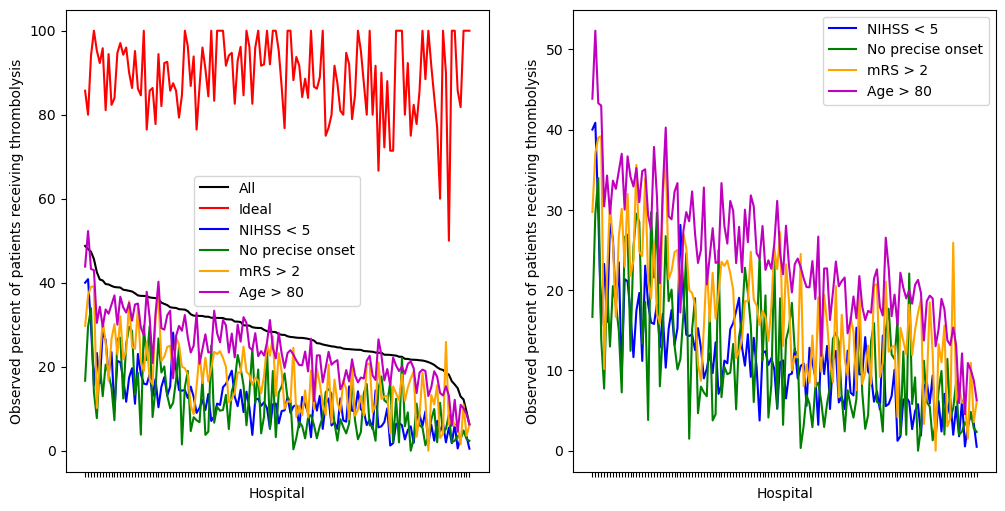

In [5]:
sorted_results = results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(sorted_results['All patients'], label = 'All', c='k')
ax1.plot(sorted_results['Ideal'], label = 'Ideal', c='r')
ax1.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax1.plot(sorted_results['No precise onset'], label = 'No precise onset', c='g')
ax1.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax1.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax1.set_xticklabels([])
ax1.legend()
ax1.set_xlabel('Hospital')
ax1.set_ylabel('Observed percent of patients receiving thrombolysis')

ax2 = fig.add_subplot(122)
ax2.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax2.plot(sorted_results['No precise onset'], label = 'No precise onset', c='g')
ax2.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax2.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax2.set_xticklabels([])
ax2.legend()
ax2.set_xlabel('Hospital')
ax2.set_ylabel('Observed percent of patients receiving thrombolysis')

plt.savefig('./output/15a_actual_subgroup.jpg', dpi=300)

plt.show()

In [6]:
results

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,Age > 80,NIHSS + Precise,NIHSS + Disability,Precise + Disability,NIHSS + Precise + Disability
AGNOF1041H,35.246843,82.051282,15.210356,18.623482,21.379310,29.189189,2.409639,0.000000,8.771930,0.000000
AKCGO9726K,36.974790,86.206897,23.049645,18.539326,33.887043,35.044248,8.275862,10.606061,17.177914,4.761905
AOBTM3098N,21.880342,80.000000,2.690583,5.813953,11.926606,18.309859,0.000000,0.000000,5.555556,0.000000
APXEE8191H,22.648084,100.000000,6.329114,12.356322,13.636364,20.270270,2.597403,0.000000,5.333333,0.000000
ATDID5461S,24.038462,100.000000,14.150943,2.727273,9.756098,16.265060,0.000000,7.142857,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,24.605678,87.500000,5.185185,2.409639,11.475410,21.568627,0.000000,5.555556,0.000000,0.000000
YQMZV4284N,23.617021,100.000000,7.389163,6.074766,20.754717,22.594142,0.000000,2.439024,5.681818,0.000000
ZBVSO0975W,25.000000,76.923077,12.435233,14.705882,20.512821,23.560209,22.222222,0.000000,4.166667,0.000000
ZHCLE1578P,22.363946,100.000000,6.067416,22.070145,18.181818,20.000000,6.067416,2.325581,18.279570,2.325581


Show correlations between major subgroups.

In [7]:
print ('Correlations between subgroups:')
print ('-------------------------------')
cols = ['All patients', 'Ideal', 'NIHSS < 5', 'No precise onset', 'mRS > 2']
for i in range (len(cols)):
    for j in range(i+1, (len(cols))):
        f1 = cols[i]
        f2 = cols[j]
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(results[f1], results[f2])
        r_square = r_value ** 2
        print (f'{f1} - {f2}: r-square = {r_square:0.3f}, p = {p_value:0.4f}')

Correlations between subgroups:
-------------------------------
All patients - Ideal: r-square = 0.006, p = 0.3646
All patients - NIHSS < 5: r-square = 0.661, p = 0.0000
All patients - No precise onset: r-square = 0.344, p = 0.0000
All patients - mRS > 2: r-square = 0.528, p = 0.0000
Ideal - NIHSS < 5: r-square = 0.003, p = 0.5198
Ideal - No precise onset: r-square = 0.000, p = 0.8747
Ideal - mRS > 2: r-square = 0.010, p = 0.2583
NIHSS < 5 - No precise onset: r-square = 0.221, p = 0.0000
NIHSS < 5 - mRS > 2: r-square = 0.308, p = 0.0000
No precise onset - mRS > 2: r-square = 0.289, p = 0.0000


## Show summary of results

In [8]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
All patients,132.0,28.618779,7.645344,6.250000,23.513019,28.007450,33.659365,48.756219
Ideal,132.0,89.175667,9.197675,50.000000,83.982143,90.454545,96.038462,100.000000
NIHSS < 5,132.0,11.422620,6.965480,0.490196,6.420988,10.572275,14.489520,40.845070
No precise onset,132.0,11.576738,7.882359,0.000000,5.263158,10.027830,16.461749,33.949192
mRS > 2,132.0,17.225861,8.150170,0.000000,11.085627,17.004327,22.443219,39.166667
Age > 80,132.0,24.086885,8.144390,4.545455,18.956249,23.205515,29.754550,52.307692
NIHSS + Precise,132.0,4.185051,4.891655,0.000000,0.000000,2.667141,6.274700,25.925926
NIHSS + Disability,132.0,4.089944,5.230294,0.000000,0.000000,2.964427,6.250000,28.571429
Precise + Disability,132.0,7.266829,6.822990,0.000000,1.895749,5.555556,10.638639,30.000000
NIHSS + Precise + Disability,131.0,1.769021,4.384437,0.000000,0.000000,0.000000,0.000000,33.333333


## Violin plot of results

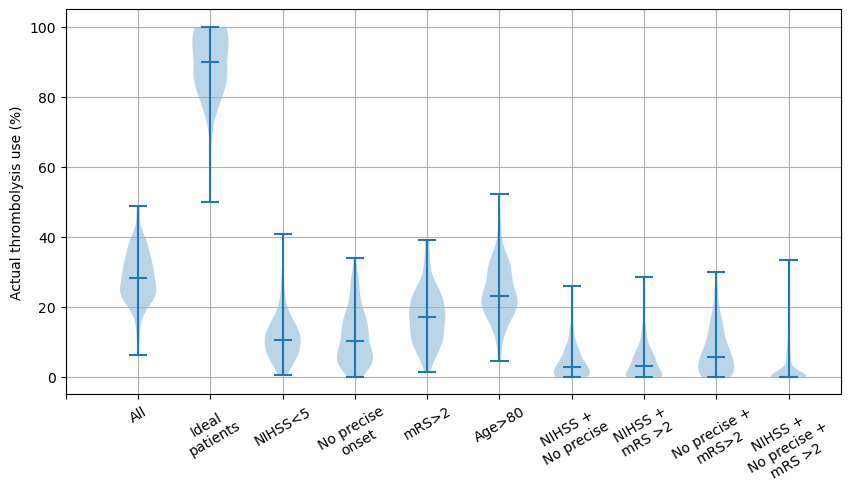

In [9]:
cols = ['All patients', 'Ideal', 'NIHSS < 5', 'No precise onset', 'mRS > 2', 'Age > 80',
        'NIHSS + Precise', 'NIHSS + Disability', 'Precise + Disability', 'NIHSS + Precise + Disability']
labels = ['', 'All', 'Ideal\npatients', 'NIHSS<5', 'No precise\nonset', 'mRS>2', 'Age>80',
          'NIHSS +\nNo precise', 'NIHSS +\nmRS >2', 'No precise +\nmRS>2', 'NIHSS + \nNo precise +\nmRS >2']
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.violinplot(results[cols].dropna(), showmedians=True)
ax.set_ylabel('Actual thrombolysis use (%)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30)
ax.grid()
plt.savefig('./output/15a_actual_subgroup_violin.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

## Compare with model results

Model results saved in notebook 15.

In [10]:
model_results = pd.read_csv('./output/15_10k_groups.csv', index_col='Unnamed: 0')

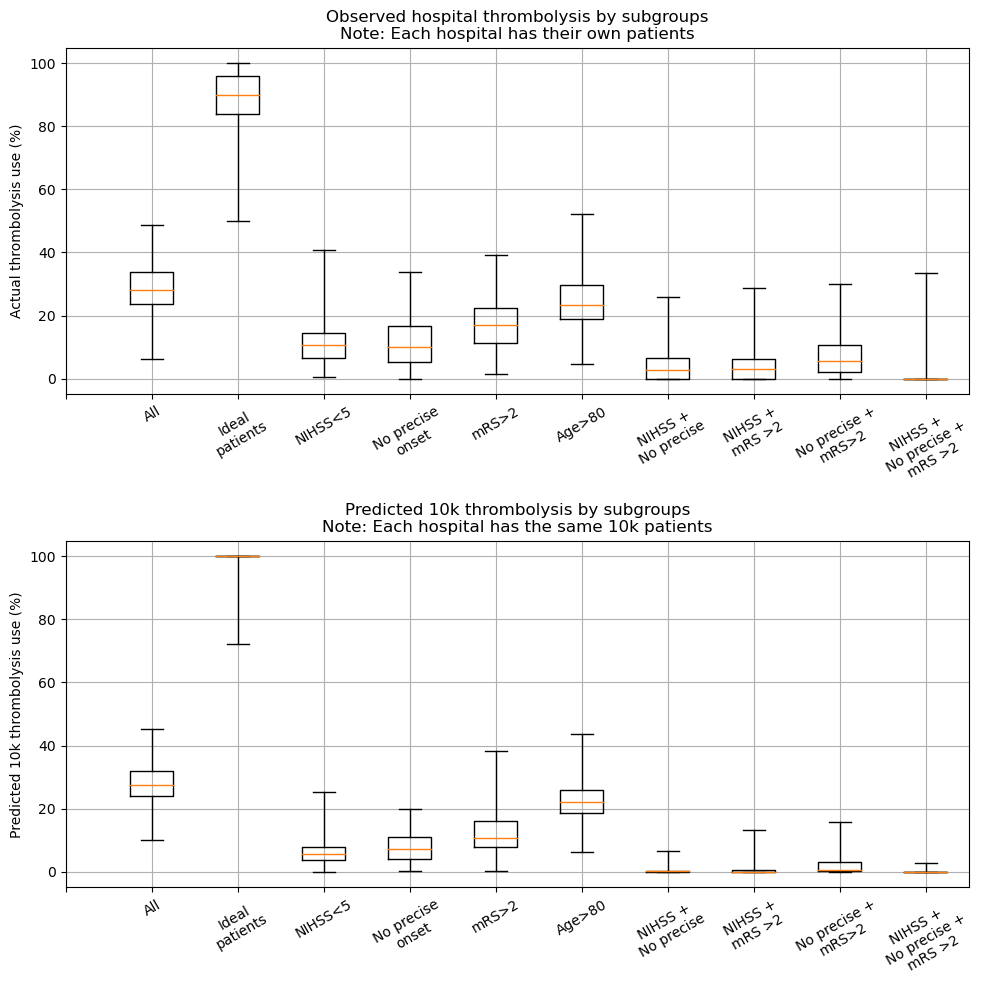

In [11]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
ax1.boxplot(results[cols].dropna(),whis=[0,100])
ax1.set_ylabel('Actual thrombolysis use (%)')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=30)
ax1.grid()
ax1.set_title('Observed hospital thrombolysis by subgroups\n'
              'Note: Each hospital has their own patients')

ax2 = fig.add_subplot(212)
ax2.boxplot(model_results[cols].dropna(),whis=[0,100])
ax2.set_ylabel('Predicted 10k thrombolysis use (%)')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=30)
ax2.grid()
ax2.set_title('Predicted 10k thrombolysis by subgroups\n'
              'Note: Each hospital has the same 10k patients')

plt.tight_layout(pad=1)
plt.savefig('./output/15a_actual_vs_modelled_subgroup_violin.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

### Check correlations betwen subgroups

In [12]:
pairs_to_test = [
    ['All patients', 'NIHSS < 5'],
    ['All patients', 'No precise onset'],
    ['All patients', 'mRS > 2'],
    ['All patients', 'Age > 80'],
    ['NIHSS < 5', 'No precise onset'],
    ['NIHSS < 5', 'mRS > 2'],
    ['NIHSS < 5', 'Age > 80'],
    ['No precise onset', 'mRS > 2'],
    ['No precise onset', 'Age > 80'],
    ['mRS > 2', 'Age > 80']]

for pair in pairs_to_test:
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(results[pair[0]],results[pair[1]])
    print (f'Correlation between {pair[0]} and {pair[1]}:'
           f'\n  r-squared = {r_value**2:0.3f}, p = {p_value:0.3f}\n')

Correlation between All patients and NIHSS < 5:
  r-squared = 0.661, p = 0.000

Correlation between All patients and No precise onset:
  r-squared = 0.344, p = 0.000

Correlation between All patients and mRS > 2:
  r-squared = 0.528, p = 0.000

Correlation between All patients and Age > 80:
  r-squared = 0.801, p = 0.000

Correlation between NIHSS < 5 and No precise onset:
  r-squared = 0.221, p = 0.000

Correlation between NIHSS < 5 and mRS > 2:
  r-squared = 0.308, p = 0.000

Correlation between NIHSS < 5 and Age > 80:
  r-squared = 0.473, p = 0.000

Correlation between No precise onset and mRS > 2:
  r-squared = 0.289, p = 0.000

Correlation between No precise onset and Age > 80:
  r-squared = 0.342, p = 0.000

Correlation between mRS > 2 and Age > 80:
  r-squared = 0.680, p = 0.000



## Check correlations between observed and predicted subgroup thrombolysis

In [13]:
# Collate results\
compare_df = pd.DataFrame()
compare_df['predicted'] = model_results.values.flatten()
compare_df['observed'] = results.values.flatten()
compare_df.dropna(inplace=True)

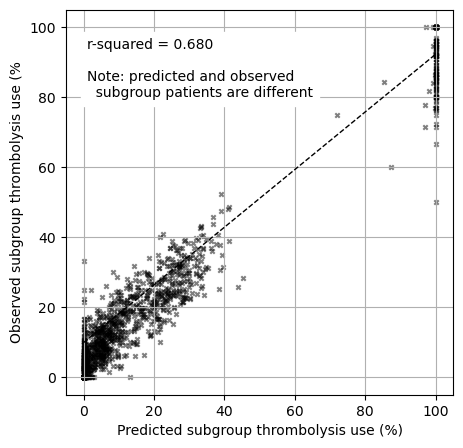

In [14]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(compare_df['predicted'], compare_df['observed'], 
    marker='x', s=10, c='k', alpha=0.5)
# Add best fit
ax.plot([0, 100], [intercept, intercept + (100 * slope)], 
    linestyle='--', c='k', linewidth=1)

ax.set_xlabel('Predicted subgroup thrombolysis use (%)')
ax.set_ylabel('Observed subgroup thrombolysis use (%')

text = (f'r-squared = {r_value**2:0.3f}\n\n'
    'Note: predicted and observed\n  subgroup patients are different')

ax.text(1, 80, text, bbox=dict(facecolor='white', edgecolor='white'))
ax.grid()
plt.savefig('./output/15a_subgroup_correlation.jpg', dpi=300)
plt.show()

The observed and predicted subgroup analysis show very similar general patterns (with r-sqaured=0.95). Some differences exist:
* The use of thrombolysi in *ideal* patients is a little low in the observed vs actual results (mean hopsital thrombolysis use = 89% vs 99%).
* The predicted results show a stronger effect of combining non-ideal features.